# Bankrupt dataset ETL

Librerie varie da installare

In [34]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn

Inclusione delle librerie utilizzate

In [35]:
import pandas as pd
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Variabili di gestione files

In [36]:
# Path of the file, can be changed
PATH_BANKRUPT = r"C:\Users\Andre\OneDrive - Università degli Studi di Parma\Tirocinio\Dataset\Bankruptcy_rielaborati_G"

# True = export summary file in the OUTPUT_PATH
to_export = False

# Path of the desired output file, can be changed
OUTPUT_PATH = r"C:\Users\Andre\OneDrive - Università degli Studi di Parma\Tirocinio\Dataset_filtrato"

Leggo, per esempio, i file .csv contenuti in una directory e le sue sottodirectories (BANKRUPT)

In [37]:
# Dataset with all the csv files
input_dataset = pd.DataFrame()

# Path of each csv file
# Path descrption: Bankruptcy_rielaborate_G/*.csv
csv_files = glob.glob(os.path.join(PATH_BANKRUPT, "**/*.csv"), recursive=True)

# Loop over the list of csv files
for f in csv_files:

    # Print the location and filename
    print('Location:', f)
    print('File Name:', f.split("\\")[-1])

    # Read each csv file
    partial_dataset = pd.read_csv(f, sep=";", dtype=object, thousands=",", decimal=".")

    # Append the partial dataset
    input_dataset = pd.concat([input_dataset, partial_dataset])




print("Dimensione dataset delle società in attivo: ", input_dataset.shape)

Location: C:\Users\Andre\OneDrive - Università degli Studi di Parma\Tirocinio\Dataset\Bankruptcy_rielaborati_G\Year - 1Aida_Export_Bank_1_30000_clean_GG.csv
File Name: Year - 1Aida_Export_Bank_1_30000_clean_GG.csv
Location: C:\Users\Andre\OneDrive - Università degli Studi di Parma\Tirocinio\Dataset\Bankruptcy_rielaborati_G\Year - 1Aida_Export_Bank_30001_60000_clean_GG.csv
File Name: Year - 1Aida_Export_Bank_30001_60000_clean_GG.csv
Location: C:\Users\Andre\OneDrive - Università degli Studi di Parma\Tirocinio\Dataset\Bankruptcy_rielaborati_G\Year - 1Aida_Export_Bank_60001_90000_clean_GG.csv
File Name: Year - 1Aida_Export_Bank_60001_90000_clean_GG.csv
Location: C:\Users\Andre\OneDrive - Università degli Studi di Parma\Tirocinio\Dataset\Bankruptcy_rielaborati_G\Year - 1Aida_Export_Bank_90001_111495_clean_GG.csv
File Name: Year - 1Aida_Export_Bank_90001_111495_clean_GG.csv
Location: C:\Users\Andre\OneDrive - Università degli Studi di Parma\Tirocinio\Dataset\Bankruptcy_rielaborati_G\Year - 

In [38]:
input_dataset

,Unnamed: 0,Company name,Province,Accounting closing date\r\nLast avail. yr,Number of employees\r\nLast avail. yr,Tax code number,CCIAA number,VAT number,No of available years,Legal form,...,Current taxes\r\nEUR\r\nYear - 4,Taxation related to previous years\r\nEUR\r\nYear - 4,Prepaid and deferred taxes\r\nEUR\r\nYear - 4,deferred taxation (+/-)\r\nEUR\r\nYear - 4,advance taxation (+/-)\r\nEUR\r\nYear - 4,Income (expenses) for adherence to fiscal transparency regime\r\nEUR\r\nYear - 4,PROFIT (LOSS)\r\nEUR\r\nYear - 4,PROFIT (LOSS) THIRD PARTIES\r\nEUR\r\nYear - 4,PROFIT (LOSS) GROUP\r\nEUR\r\nYear - 4,Employees\r\nYear - 4
0,1,& GI S.R.L. IN LIQUIDAZIONE,Caserta,39813,22,7830680638,CE0226176,7830680638,5,Limited liability company - SRL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,&-CO HOLDING S.R.L.,Rovigo,38352,0,999200298,RO0108645,NaN,3,One-person company with limited liability - SRL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,&CO S.R.L.,Venezia,40543,3,3803330277,VE0339936,3803330277,4,One-person company with limited liability - SRL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,'' ANTIFURTITALIA SOCIETA' A RESPONSABILITA' L...,Roma,42004,4,10827711002,RM1258470,10827711002,5,Limited liability company - SRL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,'' MA.S. CASA S.R.L.,Roma,40178,0,7533811001,RM1038487,7533811001,6,Limited liability company - SRL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12954,21485,ZUMBO CALCESTRUZZI S.R.L. IN LIQUIDAZIONE,Catania,41274,0,4408390872,CT0293576,NaN,7,Limited liability company - SRL,...,5927,0,0,0,0,0,-80880,0,-80880,9
12955,21487,ZURIGO IMMOBILIARE S.R.L.,Milano,37256,4,963440284,MI1459242,11338360156,6,Limited liability company - SRL,...,0,0,0,0,0,0,-181051,0,-181051,2
12956,21489,ZUSICAFF SRL,Cosenza,42004,2,2103390783,CS0142568,2103390783,10,Limited liability company - SRL,...,0,0,0,0,0,0,21581,0,21581,0
12957,21490,ZV S.R.L.,Piacenza,38717,0,1042270338,PC0123330,1042270338,10,Limited liability company - SRL,...,0,0,0,0,0,0,1179,0,1179,39


Gestisco i nomi delle colonne in modo consistente

In [39]:
for col in input_dataset.columns:
    old_col_name = col
    new_col_name = re.sub("\r\nEUR\r\nYear - \d|\r\nYear - \d|\nEUR\nYear - \d|Year - \d|EUR", "", old_col_name)
    new_col_name = re.sub("\r\n|\r|\n", " ", new_col_name)
    input_dataset.rename(columns={old_col_name: new_col_name}, inplace=True)

In [40]:
# Combine all columns with the same name
input_dataset = input_dataset.groupby(level=0, axis=1).sum()

Seleziono solo le colonne che mi interessano per il calcolo degli indici

In [41]:
# Massive amount of columns needed to compute different financial estimators
to_keep_columns = ['Company name',
                   'Province',
                   'Employees',
                   'Accounting closing date Last avail. yr',
                   'Legal form',
                   'Legal status',
                   'Total financial charges',
                   "TOTAL SHAREHOLDERS' FUNDS",
                   'TOTAL CURRENT ASSETS',
                   'OPERATING MARGIN',
                   "Total depreciation, amortization and writedowns",
                   'Provisions fo risks and charges',
                   'Other provisions',
                   'Tax payable',
                   'Tax payable beyond 12 months',
                   'Due to social security institutions',
                   'Due to social security institutions - beyond 12 months',
                   'TOTAL FIXED ASSETS',
                   'PROFIT (LOSS) GROUP',
                   'Trade accounts',
                   'Trade accounts - beyond 12 months',
                   'Due to suppliers',
                   'Due to suppliers - beyond 12 months',
                   'TOTAL INVENTORIES',
                   'Due to banks',
                   'Due to banks - beyond 12 months',
                   'Due to other lenders',
                   'Due to other lenders - beyond 12 months',
                   'Bonds',
                   'Bonds beyond 12 months',
                   'Due to shar. for loans',
                   'Due to sharesholders for loans - beyond 12 months',
                   'Revenues from sales and services',
                   'TOTAL LIQUID FUNDS',
                   'TOTAL PAYABLES',
                   'Total payables during period',
                   'Total payables after period',
                   'TOTAL ASSETS',
                   "TOTAL LIABILITIES AND SHAREHOLDERS' FUNDS",
                   'Raw, consum. mat. and goods for resale',
                   'Services']

input_dataset = input_dataset[to_keep_columns]

In [42]:
input_dataset.head()

,Company name,Province,Employees,Accounting closing date Last avail. yr,Legal form,Legal status,Total financial charges,TOTAL SHAREHOLDERS' FUNDS,TOTAL CURRENT ASSETS,OPERATING MARGIN,...,Due to sharesholders for loans - beyond 12 months,Revenues from sales and services,TOTAL LIQUID FUNDS,TOTAL PAYABLES,Total payables during period,Total payables after period,TOTAL ASSETS,TOTAL LIABILITIES AND SHAREHOLDERS' FUNDS,"Raw, consum. mat. and goods for resale",Services
0,& GI S.R.L. IN LIQUIDAZIONE,Caserta,20,39813,Limited liability company - SRL,Bankruptcy,88877,377370,3863851,191867,...,657500,5833376,68683,4569356,3911856,657500,4991042,4991042,4216522,370915
1,&-CO HOLDING S.R.L.,Rovigo,4,38352,One-person company with limited liability - SRL,Bankruptcy,62247,177314,2143638,79212,...,0,6254777,80588,2112704,2112704,0,2295625,2295625,5807824,429081
2,&CO S.R.L.,Venezia,4,40543,One-person company with limited liability - SRL,Bankruptcy,10001,-55326,241956,-93342,...,0,688230,5796,355492,355492,0,307294,307294,532913,78036
3,'' ANTIFURTITALIA SOCIETA' A RESPONSABILITA' L...,Roma,4,42004,Limited liability company - SRL,Bankruptcy,3,232726,961087,-31879,...,0,239850,10848,748170,748170,0,992754,992754,89816,38566
4,'' MA.S. CASA S.R.L.,Roma,0,40178,Limited liability company - SRL,Bankruptcy,7974,50644,294671,24885,...,0,1482533,10333,266994,266994,0,318147,318147,1304026,236940


Rinomino certe colonne per essere consistente con il dataset delle companie in attivo

In [43]:
map_columns = {
    "Company name": "Ragione sociale",
    "Employees": "Number of employees",
    "Legal form": "Legal Form",
    "Legal status": "Legal Status",
    "TOTAL SHAREHOLDERS' FUNDS": "TOTAL SHAREHOLDERS FUNDS",
    "Accounting closing date Last avail. yr": "Accounting closing date",
    "TOTAL ASSETS": "Total asset",
    "TOTAL LIABILITIES AND SHAREHOLDERS' FUNDS": "TOTAL LIABILITIES AND SHAREHOLDERS FUNDS",
    "Due to shar. for loans": "Due to shareholders for loans"
}
input_dataset.rename(columns=map_columns, inplace=True)

In [44]:
input_dataset

,Ragione sociale,Province,Number of employees,Accounting closing date,Legal Form,Legal Status,Total financial charges,TOTAL SHAREHOLDERS FUNDS,TOTAL CURRENT ASSETS,OPERATING MARGIN,...,Due to sharesholders for loans - beyond 12 months,Revenues from sales and services,TOTAL LIQUID FUNDS,TOTAL PAYABLES,Total payables during period,Total payables after period,Total asset,TOTAL LIABILITIES AND SHAREHOLDERS FUNDS,"Raw, consum. mat. and goods for resale",Services
0,& GI S.R.L. IN LIQUIDAZIONE,Caserta,20,39813,Limited liability company - SRL,Bankruptcy,88877,377370,3863851,191867,...,657500,5833376,68683,4569356,3911856,657500,4991042,4991042,4216522,370915
1,&-CO HOLDING S.R.L.,Rovigo,4,38352,One-person company with limited liability - SRL,Bankruptcy,62247,177314,2143638,79212,...,0,6254777,80588,2112704,2112704,0,2295625,2295625,5807824,429081
2,&CO S.R.L.,Venezia,4,40543,One-person company with limited liability - SRL,Bankruptcy,10001,-55326,241956,-93342,...,0,688230,5796,355492,355492,0,307294,307294,532913,78036
3,'' ANTIFURTITALIA SOCIETA' A RESPONSABILITA' L...,Roma,4,42004,Limited liability company - SRL,Bankruptcy,3,232726,961087,-31879,...,0,239850,10848,748170,748170,0,992754,992754,89816,38566
4,'' MA.S. CASA S.R.L.,Roma,0,40178,Limited liability company - SRL,Bankruptcy,7974,50644,294671,24885,...,0,1482533,10333,266994,266994,0,318147,318147,1304026,236940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12954,ZUMBO CALCESTRUZZI S.R.L. IN LIQUIDAZIONE,Catania,9,41274,Limited liability company - SRL,Bankruptcy,2002,14039,1064062,-73617,...,370000,824936,10887,1274497,904497,370000,1306445,1306445,381567,141405
12955,ZURIGO IMMOBILIARE S.R.L.,Milano,2,37256,Limited liability company - SRL,Bankruptcy,372321,672153,6992657,190949,...,0,27682,17708,6725700,6725700,0,7431862,7431862,2502547,420721
12956,ZUSICAFF SRL,Cosenza,0,42004,Limited liability company - SRL,Bankruptcy,33367,484086,466957,46048,...,0,778618,5186,1143996,658854,485142,1639308,1639308,323927,135348
12957,ZV S.R.L.,Piacenza,39,38717,Limited liability company - SRL,Dissolved (bankruptcy),102543,133317,2031348,148441,...,0,2793954,110578,3568435,2656534,911902,3929669,3929669,1044332,450059


Tutti i valori non disponibili sono rimpiazzati con NaN

In [45]:
input_dataset.replace(to_replace="n.a.", value=np.NaN, inplace=True)
input_dataset.replace(to_replace="n.d.", value=np.NaN, inplace=True)
input_dataset.replace(to_replace="#VALUE!", value=np.NaN, inplace=True)
input_dataset.replace(to_replace="#NOME?", value=np.NaN, inplace=True)
input_dataset.replace(to_replace="UDATACHI", value=np.NaN, inplace=True)
input_dataset.isna().sum()

Ragione sociale                                           10
Province                                                   0
Number of employees                                        0
Accounting closing date                                    0
Legal Form                                                 0
Legal Status                                               0
Total financial charges                                    0
TOTAL SHAREHOLDERS FUNDS                                   0
TOTAL CURRENT ASSETS                                       0
OPERATING MARGIN                                           0
Total depreciation, amortization and writedowns            0
Provisions fo risks and charges                            0
Other provisions                                           0
Tax payable                                                0
Tax payable beyond 12 months                               0
Due to social security institutions                        0
Due to social security i

Rimuovo tutti i record contenenti valori NaN

In [46]:
input_dataset.dropna(inplace=True)
input_dataset.isna().sum()

Ragione sociale                                           0
Province                                                  0
Number of employees                                       0
Accounting closing date                                   0
Legal Form                                                0
Legal Status                                              0
Total financial charges                                   0
TOTAL SHAREHOLDERS FUNDS                                  0
TOTAL CURRENT ASSETS                                      0
OPERATING MARGIN                                          0
Total depreciation, amortization and writedowns           0
Provisions fo risks and charges                           0
Other provisions                                          0
Tax payable                                               0
Tax payable beyond 12 months                              0
Due to social security institutions                       0
Due to social security institutions - be

In [47]:
print("Dimensione dataset filtrato dai valori mancanti e con numero di colonne ridotte: ", input_dataset.shape)

Dimensione dataset filtrato dai valori mancanti e con numero di colonne ridotte:  (332050, 41)


Cast delle colonne del dataset a tipi numerici e descrittivi (stringhe)

In [48]:
str_cols = ['Ragione sociale',
            'Province',
            'Legal Form',
            'Legal Status',
            'Accounting closing date']

for col in input_dataset.columns:
    if col in str_cols:
        input_dataset[col] = input_dataset[col].astype(str)
    else:
        input_dataset[col] = pd.to_numeric(input_dataset[col])

Rendo la colonna Legal Status contenente un unico valore (Bankruptcy)

In [49]:
input_dataset["Legal Status"] = "Bankruptcy"

Breve panoramica del dataset bankrupt

In [50]:
input_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Number of employees,332050,12,193,0,0,1,9,61904
Total financial charges,332050,104398,1964052,-5307809,3388,19489,66368,812193000
TOTAL SHAREHOLDERS FUNDS,332050,335725,23044985,-1348770829,9505,42325,172395,8828665000
TOTAL CURRENT ASSETS,332050,2951976,28849961,0,302100,792130,2078560,9392512000
OPERATING MARGIN,332050,-76305,14361228,-7759571000,-10342,20981,78884,1004223000
"Total depreciation, amortization and writedowns",332050,126745,2297491,-809375,2952,15296,51463,507732647
Provisions fo risks and charges,332050,16143,566288,-2368808,0,0,0,180496000
Other provisions,332050,5981,312104,-2579468,0,0,0,112724277
Tax payable,332050,164616,1428983,-937549,0,13740,86584,501080000
Tax payable beyond 12 months,332050,25982,403031,-295443,0,0,0,56881522


Inizio a calcolare i vari indicatori

In [51]:
# Max estimator value
MAX_VALUE_INDEX = 10
# Min estimator value
MIN_VALUE_INDEX = -10

Indicatori di allerta

In [52]:
input_dataset["OF/Ricavi"] = input_dataset["Total financial charges"] / input_dataset["Revenues from sales and services"]

input_dataset["PN/Totale Debiti"] = input_dataset["TOTAL SHAREHOLDERS FUNDS"] / input_dataset["TOTAL PAYABLES"]

input_dataset["Att. Br/Pass. Br"] = input_dataset["TOTAL CURRENT ASSETS"] / input_dataset["Total payables during period"]

input_dataset["EBITDA/Attivo"] = (input_dataset["OPERATING MARGIN"] +
                                  input_dataset["Total depreciation, amortization and writedowns"] +
                                  input_dataset["Provisions fo risks and charges"]) / input_dataset["Total asset"]

input_dataset["Deb. Prev + Trib/Attivo"] = (input_dataset["Tax payable"] +
                                            input_dataset["Tax payable beyond 12 months"] +
                                            input_dataset["Due to social security institutions"] +
                                            input_dataset["Due to social security institutions - beyond 12 months"]) / input_dataset["Total asset"]

In [53]:
allerta_indexes = ["OF/Ricavi", "PN/Totale Debiti", "Att. Br/Pass. Br", "EBITDA/Attivo", "Deb. Prev + Trib/Attivo"]
input_dataset[allerta_indexes]

,OF/Ricavi,PN/Totale Debiti,Att. Br/Pass. Br,EBITDA/Attivo,Deb. Prev + Trib/Attivo
0,0,0,0,0,0
1,0,0,1,0,0
2,0,0,0,0,0
3,0,0,1,0,0
4,0,0,1,0,0
...,...,...,...,...,...
12954,0,0,1,0,0
12955,13,0,1,0,0
12956,0,0,0,0,0
12957,0,0,0,0,0


In [54]:
input_dataset[allerta_indexes].describe().T

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

Indicatori provenienti dalla letteratura

In [55]:
input_dataset["Attivo fisso/Totale Passivita"] = input_dataset["TOTAL FIXED ASSETS"] / input_dataset["TOTAL LIABILITIES AND SHAREHOLDERS FUNDS"]

input_dataset["ROE"] = input_dataset["PROFIT (LOSS) GROUP"] / input_dataset["TOTAL SHAREHOLDERS FUNDS"]

input_dataset["Tempo medio riscossione (TMR)"] = (input_dataset["Trade accounts"] +
                                                  input_dataset["Trade accounts - beyond 12 months"] ) / (input_dataset["Revenues from sales and services"]/360)

input_dataset["Tempo medio di pagamento (TMP)"] = (input_dataset["Due to suppliers"] +
                                                   input_dataset["Due to suppliers - beyond 12 months"]) / (
                                                          (input_dataset["Raw, consum. mat. and goods for resale"] +
                                                           input_dataset["Services"])/360)

input_dataset["Indice liquidita Primaria (Acid Test)"] = (input_dataset["TOTAL CURRENT ASSETS"] -
                                                          input_dataset["TOTAL INVENTORIES"]) / input_dataset["Total payables during period"]

input_dataset["Indice di copertura delle immob."] = input_dataset["TOTAL FIXED ASSETS"] / (input_dataset["TOTAL SHAREHOLDERS FUNDS"] + input_dataset["Total payables after period"])

input_dataset["Indice copertura On.Fin."] = input_dataset["OPERATING MARGIN"] / input_dataset["Total financial charges"]

input_dataset["Indice copertura On.Fin. Con liquidita"] = (input_dataset["OPERATING MARGIN"] +
                                                           input_dataset["Total depreciation, amortization and writedowns"] +
                                                           input_dataset["Provisions fo risks and charges"] +
                                                           input_dataset["Other provisions"]) / input_dataset["Total financial charges"]
# Common numerator - begin
numerator = (input_dataset["Due to banks"] +
             input_dataset["Due to banks - beyond 12 months"] +
             input_dataset["Due to other lenders"] +
             input_dataset["Due to other lenders - beyond 12 months"] +
             input_dataset["Bonds"] +
             input_dataset["Bonds beyond 12 months"] +
             input_dataset["Due to shareholders for loans"] +
             input_dataset["Due to sharesholders for loans - beyond 12 months"] -
             input_dataset["TOTAL LIQUID FUNDS"])

input_dataset["PFN/EBITDA"] = numerator / (input_dataset["OPERATING MARGIN"] +
                                           input_dataset["Total depreciation, amortization and writedowns"] +
                                           input_dataset["Provisions fo risks and charges"] +
                                           input_dataset["Other provisions"])

input_dataset["PFN/PN"] = numerator / input_dataset["TOTAL SHAREHOLDERS FUNDS"]

input_dataset["PFN/Vendite"] = numerator / input_dataset["Revenues from sales and services"]

input_dataset["Gearing"] = numerator / (numerator + input_dataset["TOTAL SHAREHOLDERS FUNDS"])
# Common numerator - end

input_dataset["ROS"] = input_dataset["OPERATING MARGIN"] / input_dataset["Revenues from sales and services"]

input_dataset["Turnover capitale investito"] = (input_dataset["Revenues from sales and services"]/360) / input_dataset["Total asset"]

input_dataset["Working capital/net sales"] = input_dataset["TOTAL CURRENT ASSETS"] / input_dataset["Revenues from sales and services"]

input_dataset["Cash/Current Liabilities"] = input_dataset["TOTAL LIQUID FUNDS"] / input_dataset["Total payables during period"]

input_dataset["Accounts receivable/inventory"] = (input_dataset["Trade accounts"] + input_dataset["Trade accounts - beyond 12 months"]) / input_dataset["TOTAL INVENTORIES"]

input_dataset["EBIT/interest expenses"] = input_dataset["OPERATING MARGIN"] / input_dataset["Total financial charges"]

In [56]:
letteratura_indexes = ["Attivo fisso/Totale Passivita",
                       "ROE",
                       "Tempo medio riscossione (TMR)",
                       "Tempo medio di pagamento (TMP)",
                       "Indice liquidita Primaria (Acid Test)",
                       "Indice di copertura delle immob.",
                       "Indice copertura On.Fin.",
                       "Indice copertura On.Fin. Con liquidita",
                       "PFN/EBITDA",
                       "PFN/PN",
                       "PFN/Vendite",
                       "Gearing",
                       "ROS",
                       "Turnover capitale investito",
                       "Working capital/net sales",
                       "Cash/Current Liabilities",
                       "Accounts receivable/inventory",
                       "EBIT/interest expenses"]
input_dataset[letteratura_indexes]

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

In [57]:
input_dataset[letteratura_indexes].describe().T

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

Indicatori di Altman Z-score

In [58]:
input_dataset["Att.Br/Attivo"] = input_dataset["TOTAL CURRENT ASSETS"] / input_dataset["Total asset"]

input_dataset["Utili non Distr./Attivo"] = input_dataset["PROFIT (LOSS) GROUP"] / input_dataset["Total asset"]

input_dataset["ROI"] = input_dataset["OPERATING MARGIN"] / input_dataset["Total asset"]

input_dataset["Ricavi/Attivo"] = input_dataset["Revenues from sales and services"] / input_dataset["Total asset"]

input_dataset["EBITDA/Totale Debiti"] = (input_dataset["OPERATING MARGIN"] +
                                         input_dataset["Total depreciation, amortization and writedowns"] +
                                         input_dataset["Provisions fo risks and charges"] +
                                         input_dataset["Other provisions"]) / input_dataset["TOTAL PAYABLES"]

In [59]:
altman_indexes = ["Att.Br/Attivo", "Utili non Distr./Attivo", "ROI", "Ricavi/Attivo", "EBITDA/Totale Debiti"]
input_dataset[altman_indexes]

,Att.Br/Attivo,Utili non Distr./Attivo,ROI,Ricavi/Attivo,EBITDA/Totale Debiti
0,0,0,0,1,0
1,0,0,0,2,0
2,0,0,0,2,0
3,0,0,0,0,0
4,0,0,0,4,0
...,...,...,...,...,...
12954,0,0,0,0,0
12955,0,0,0,0,0
12956,0,0,0,0,0
12957,0,0,0,0,0


In [60]:
input_dataset[altman_indexes].describe().T

OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

Rimuovo tutti i record con valori NaN o inf

In [61]:
filtered_dataset = input_dataset.replace(to_replace=[np.inf, -np.inf], value=np.NaN).dropna()

Guardo correlazione indicatori

<AxesSubplot:>

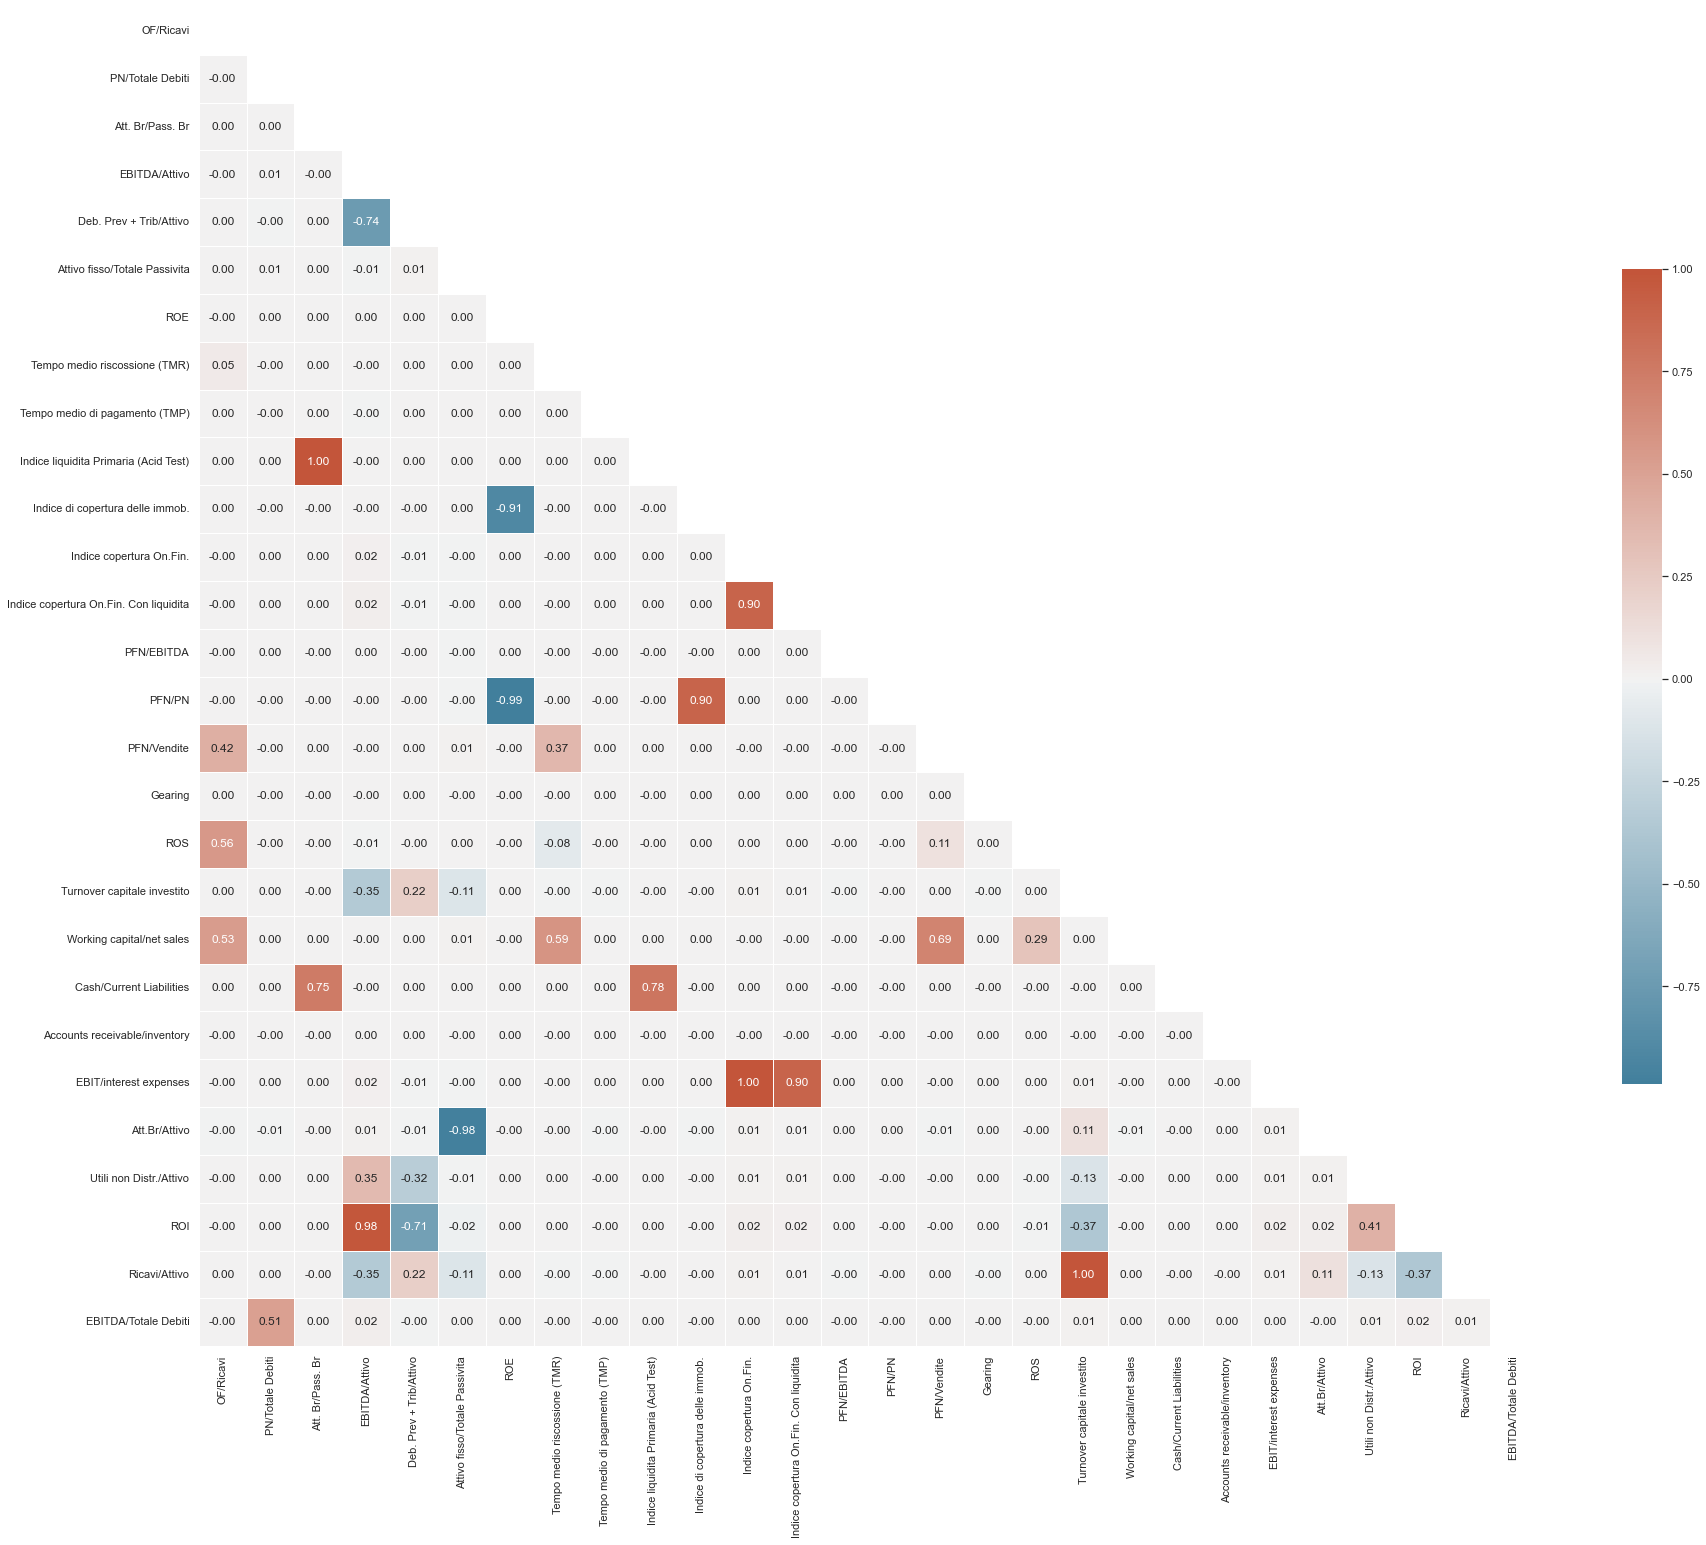

In [62]:
indexes_corr = filtered_dataset[allerta_indexes + letteratura_indexes + altman_indexes].corr()

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(indexes_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(indexes_corr, mask=mask, cmap=cmap, vmax=1,
            center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Ci sono indici estremamente correlati fra di loro, rimuovo alcuni di essi

In [63]:
removed_indexes = [# Found from active
                    "EBITDA/Attivo",
                    "OF/Ricavi",
                    "Att. Br/Pass. Br",
                    "Attivo fisso/Totale Passivita",
                    "Indice liquidita Primaria (Acid Test)",
                    "Indice copertura On.Fin.",
                    "Indice copertura On.Fin. Con liquidita",
                    "PFN/Vendite",
                    "Turnover capitale investito",
                    "Utili non Distr./Attivo",
                    # Found from bankrupt
                    "ROE",
                    "ROI",
                    "Indice di copertura delle immob."]
filtered_dataset.drop(columns=removed_indexes, axis=1, inplace=True)

<AxesSubplot:>

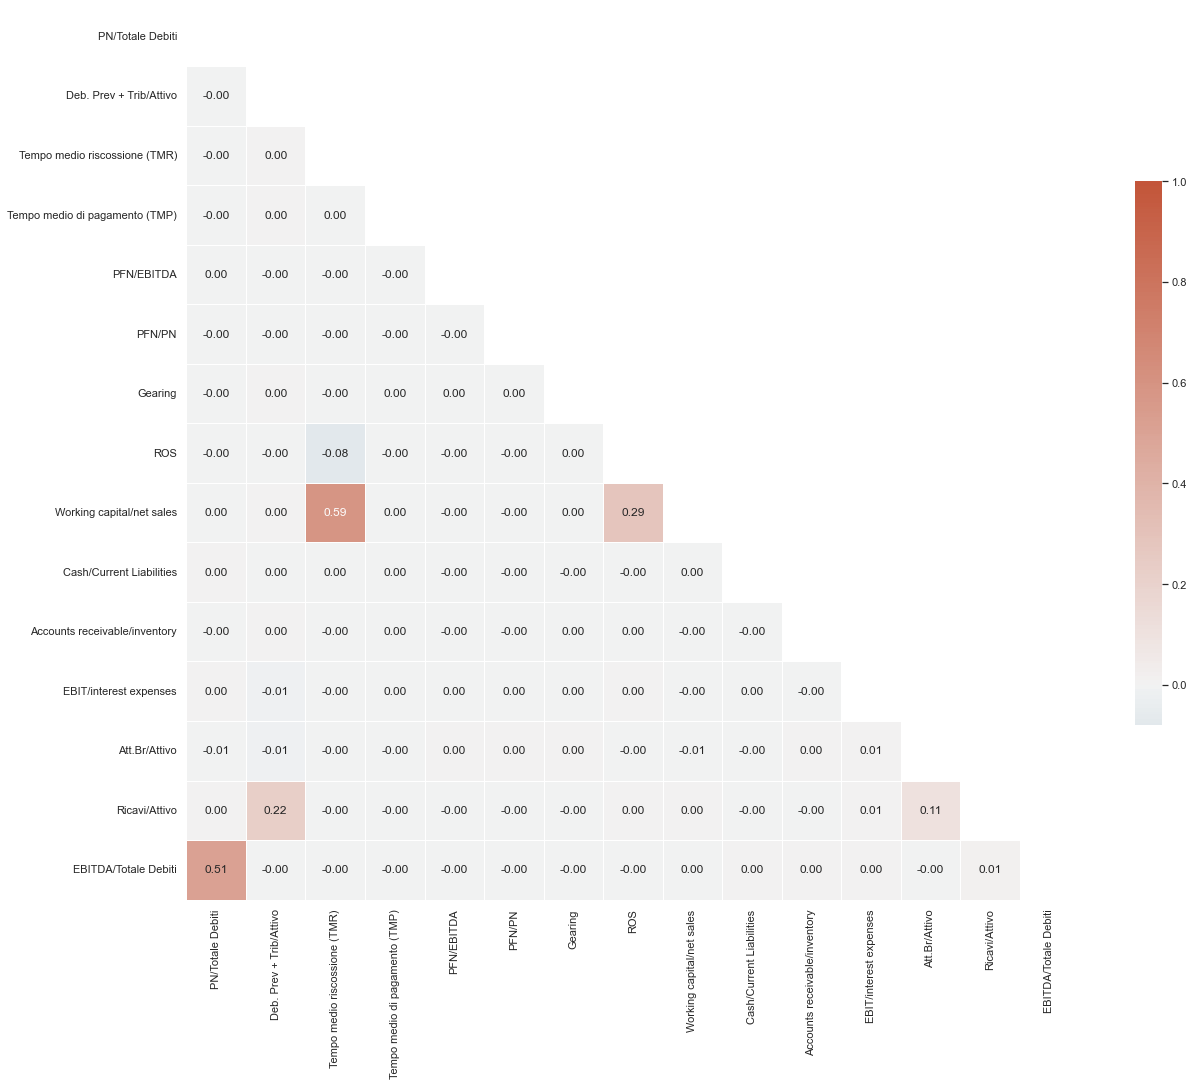

In [64]:
indexes = allerta_indexes + letteratura_indexes + altman_indexes

for index in removed_indexes:
    indexes.remove(index)

indexes_corr = filtered_dataset[indexes].corr()

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(indexes_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(indexes_corr, mask=mask, cmap=cmap, vmax=1,
            center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [65]:
pd.set_option('display.float_format', lambda x: '%i' % x)
filtered_dataset[indexes].describe().T

,count,mean,std,min,25%,50%,75%,max
PN/Totale Debiti,231775,0,12,-112,0,0,0,4654
Deb. Prev + Trib/Attivo,231775,0,0,-4,0,0,0,257
Tempo medio riscossione (TMR),231775,14713,5623947,-312508620,0,80,169,1954918080
Tempo medio di pagamento (TMP),231775,2138,462041,-596772,3,129,225,156964680
PFN/EBITDA,231775,7,1370,-165465,0,0,5,527095
PFN/PN,231775,13,3253,-82103,0,0,4,1547524
Gearing,231775,0,103,-8356,0,0,0,32374
ROS,231775,-8,4398,-1169550,0,0,0,955897
Working capital/net sales,231775,-435,71654,-8386663,0,0,1,17091276
Cash/Current Liabilities,231775,3,1480,-140,0,0,0,712466


Esporto in csv e pickle

In [66]:
if to_export:
    filtered_dataset.to_csv(OUTPUT_PATH + "/indexes_bankruptcy.csv")
    filtered_dataset.to_pickle(OUTPUT_PATH + "/indexes_bankruptcy.pkl")